In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
%%time

tweets_df = pd.read_json('../input/iphone-11-tweets-fr.json', lines=True)

CPU times: user 4.14 s, sys: 785 ms, total: 4.92 s
Wall time: 8.91 s


In [3]:
cols = ['date', 'content', 'lang']
tweets_df = tweets_df[cols]

tweets_df = tweets_df[tweets_df['lang'] == 'fr']

tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

tweets_df = tweets_df.sort_values("content") 
tweets_df = tweets_df.drop_duplicates(subset ="content", keep = 'first')

In [4]:
# supprimer les publicités et les concours
# cette liste a été générée avec https://www.tagsfinder.com/

ads_words = ['#concours', '#giveaway', '#jeuconcours', '#france', '#paris', '#concoursinstagram', '#contest',
             '#love', '#cadeau', '#réduction', '#reduction', '#solde',
            '#jeu', '#photography', '#fashion', '#beauty', '#instagood', '#picoftheday', '#makeup', 
            '#mode', '#lifestyle', '#fitness', '#jeuxconcours', '#repost', '#noel', '#instaconcours', '#girl', 
            '#calendrierdelavent', '#bijoux', '#blogger', '#photo', '#instagram', '#gift',
            'concours', 'jeuconcours', 'giveaway',
            '#gagne' ,'#gangner', 'promo', 'promotion', 'publicité',
            'contest', '#ad', '#pub', '#réduction', 'actualité', '#actualité']

tweets_df = tweets_df[~tweets_df['content'].str.contains('|'.join(ads_words), case=False)]

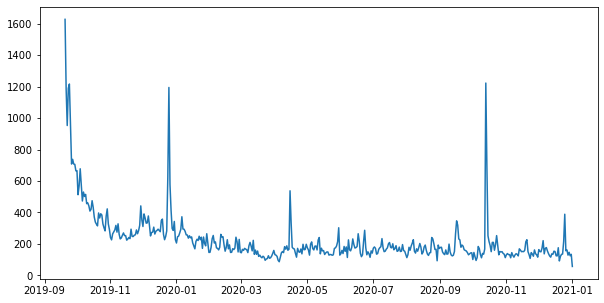

In [5]:
tweets_df['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

In [6]:
import re
import spacy

import json

from io import StringIO
from html.parser import HTMLParser

from collections import Counter 

In [7]:
# fonction pour supprimer les symbols HTML

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    '''
    input, output: string
    '''
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [8]:
# remplacement des abréviations

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
def replace_abrivot(text):
    '''
    input: string
    output: list of tokens
    '''
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

In [9]:
# lemmatization fonction (supprime les emojis et les symboles)
# Verbs are missleading
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])


#def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'ADV', 'VERB']):
def lemmatization(text, allowed_postags=['NOUN', 'ADV']):

    '''
    input: string
    output: list of tokens
    '''
    doc = nlp(text) 
    
    # garder que les sources des tokens alphabetic et qui ne sont pas des mots vides
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags 
                                and token.is_alpha 
                                and ~token.is_stop]
    return text_out

In [10]:
# fonction générale pour le prétraitement

def tweets_preprocesser(tweets):
    all_tweets=[]
    for tweet in tweets:
        
        # supprimer les symboles HTML
        reformed = strip_tags(tweet)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # remplacer les abréviations
        reformed = replace_abrivot(reformed)
        
        # lemmatization
        tokens = lemmatization(reformed)
        
        tweet_cleaned = " ".join(tokens)
        all_tweets.append(tweet_cleaned)
    all_text = ' '.join(all_tweets)
    all_words = all_text.split()
    return all_tweets, all_words

In [11]:
%%time
all_tweets, all_words = tweets_preprocesser(tweets_df['content'])

CPU times: user 4min 59s, sys: 47.5 ms, total: 4min 59s
Wall time: 4min 59s


In [12]:
# préparer la liste des mots vide, 626 mots
# importer les mots vides de la langue Française

stop_words = nlp.Defaults.stop_words

# fonction pour séléctionner les n mots le plus pertinants
# pour les rajouter dans la liste des mots vides

def select_top_words(bag_words, n_words=30):
    
    # Count all the words using Counter Method
    count_words = Counter(all_words)
    total_words=len(all_words)
    sorted_words=count_words.most_common(total_words)
    
    # select the n_words top words
    top_words = [word[0] for word in sorted_words[:n_words]]
    return top_words

# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
stop_words.update(select_top_words(all_words))

# mettre à jour la liste d'aprés le fichies des mots vides
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words.update(fr_stopwords)

In [13]:
# supprimer les mots vides
def remove_stopwords(texts):
    
    tokens = [[word for word in doc.split() if word not in stop_words] for doc in texts]
    all_tweets = [' '.join(doc) for doc in tokens if len(doc) > 1]
    #all_words = (' '.join(all_tweets)).split()
    
    return all_tweets#, all_words

all_tweets = remove_stopwords(all_tweets)

In [14]:
all_tweets[:10]

['test smartphone xr',
 'test minimum effort',
 'meuf fric voiture maison daronne l vite corde acide eau javel vite',
 'chéri bombe nokia',
 'parent abruti deg',
 'mère anniversaire',
 'bol précarité lille message',
 'way future miroir',
 'kilo besoin heure dollar samsung',
 'félicitation visiteur']

CPU times: user 1.68 s, sys: 20 ms, total: 1.7 s
Wall time: 1.75 s


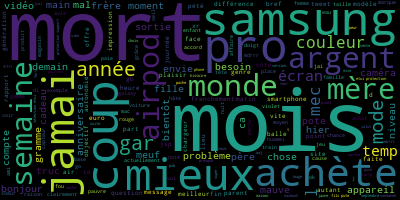

In [15]:
%%time

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ' '.join(all_tweets)

# Create a WordCloud object
wordcloud = WordCloud()

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

Les documents bruit sont définis comme ceux qui ne comportent pas de mots clés relatifs à l'iPhone 11, alors on doit extraire les mots clé du corpus et les filtrer.
Pour accomplir cette tache on vas utiliser l'Algorithm `RAKE` (the Rapid Automatic Keyword Extraction algorithm).

In [16]:
all_text = ' '.join(all_tweets)

### Library 1

In [17]:
import RAKE
rake_object = RAKE.Rake(RAKE.SmartStopList())

In [18]:
def Sort_Tuple(tup):
    tup.sort(key = lambda x: x[1], reverse=True)
    return tup

In [19]:
%%time

keywords = Sort_Tuple(rake_object.run(all_text, maxWords = 1))

print(len(keywords), 'mots clés trouvés')

266 mots clés trouvés
CPU times: user 3.15 s, sys: 19 µs, total: 3.15 s
Wall time: 3.14 s


In [20]:
print(keywords[:30])

[('euro', 1.0), ('amazon', 1.0), ('monrevepourlessoldescdiscount', 1.0), ('retraite', 1.0), ('seconde', 1.0), ('couleur', 1.0), ('fort', 1.0), ('nullité', 1.0), ('ram', 1.0), ('carte', 1.0), ('frais', 1.0), ('avai', 1.0), ('note', 1.0), ('samsung', 1.0), ('fils', 1.0), ('urgence', 1.0), ('mec', 1.0), ('million', 1.0), ('truc', 1.0), ('profondeur', 1.0), ('gap', 1.0), ('vaisselle', 1.0), ('gris', 1.0), ('télévision', 1.0), ('élément', 1.0), ('message', 1.0), ('di', 1.0), ('gagné', 1.0), ('apre', 1.0), ('enfant', 1.0)]


### Library 2

In [21]:
from multi_rake import Rake
rake = Rake(max_words=1)

In [22]:
%%time

keywords = rake.apply(all_text)
print(len(keywords), 'mots clés trouvés')

224 mots clés trouvés
CPU times: user 708 ms, sys: 3.99 ms, total: 712 ms
Wall time: 711 ms


In [23]:
print(keywords[:30])

[('atout', 1.0), ('monrevepourlessoldescdiscount', 1.0), ('fille', 1.0), ('culture', 1.0), ('truc', 1.0), ('note', 1.0), ('carte', 1.0), ('franchement', 1.0), ('remise', 1.0), ('avai', 1.0), ('samsung', 1.0), ('fils', 1.0), ('urgence', 1.0), ('mec', 1.0), ('parlant', 1.0), ('million', 1.0), ('profondeur', 1.0), ('vaisselle', 1.0), ('élément', 1.0), ('droit', 1.0), ('message', 1.0), ('besoin', 1.0), ('gagné', 1.0), ('apre', 1.0), ('enfant', 1.0), ('gamme', 1.0), ('bête', 1.0), ('telephone', 1.0), ('mois', 1.0), ('aimerai', 1.0)]


### Library 3 (Gensim uses TextRank not RAKE)

In [24]:
from gensim.summarization import keywords

In [25]:
%%time

keywords = keywords(all_text).split('\n')
print(len(keywords), 'mots clés trouvés')

3420 mots clés trouvés
CPU times: user 17.5 s, sys: 332 ms, total: 17.8 s
Wall time: 13.4 s


In [26]:
print(keywords[:30])

['mois', 'moy', 'coupe', 'argent', 'argente', 'achetent', 'achet', 'mond', 'jamai', 'ecran', 'annee', 'mecs', 'frere mode', 'temp', 'tempe', 'chose', 'niveau jamais', 'probleme', 'video', 'appareils', 'appareille', 'cadeau', 'boite airpod', 'smartphon', 'compte', 'freree', 'pete mai mal chargeur pro', 'test smartphone', 'phrase mec monde', 'mort allah']
